In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tarfile
from torchvision.datasets.utils import download_url
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./datasets')

In [6]:
data_dir='datasets/cifar10/'

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

### Data Augmentation and transformations

In [59]:
#First we'll create a stat tuple with mean and std deviation of each channel pixel 
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))   #((mean values of R,G,B),((std dev of R,G,B)))

# Now we'll creating compositions for train and val transforms
# tt.Compose() Composes several transforms together
train_tfms=tt.Compose([
    tt.RandomCrop(32,padding=4,padding_mode='reflect'), #Crop the given image at a random location , padding will padd the image borders with certain pixels before cropping and reflect method will specify that the padded pixels are reflection of pixels of image while zero padding will add black border around
    tt.RandomHorizontalFlip(), #Horizontally flip the given image randomly with a given probability. default is .5
    #tt.RandomRotation(40), #Rotate the image by given angle.
    #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), #Crop the given image to random size and aspect ratio.
    #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #Randomly change the brightness, contrast and saturation of an image.
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True) #Normalize a tensor image with mean and standard deviation.
])
#validation data does'nt require the transformations other than ToTensor and Normalization
val_tfms=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [60]:
# Getting validation (test) and train dataset with transformations
train_ds=ImageFolder(data_dir+'train',transform=train_tfms)
val_ds=ImageFolder(data_dir+'test',transform=val_tfms)

In [61]:
#creating dataloaders
batch_size=512
train_dl=DataLoader(train_ds,batch_size,pin_memory=True,num_workers=4,shuffle=True)
val_dl=DataLoader(val_ds,batch_size*2,pin_memory=True,num_workers=4)

In [62]:
#showing a batch
def denorm(images,mean,stds):
    '''Denormalizes the pixels'''
    mean=torch.tensor(mean).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+mean

def showbatch(dl):
    for i,l in dl:
        plt.figure(figsize=(12,10))
        i=denorm(i,*stats)
        plt.imshow(make_grid(i[:64],nrow=8).permute(1,2,0).clamp(0,1)) #clamp is used to keep tensors in min to max range so we specified 0to1
        plt.axis('off')
        plt.show();
        break

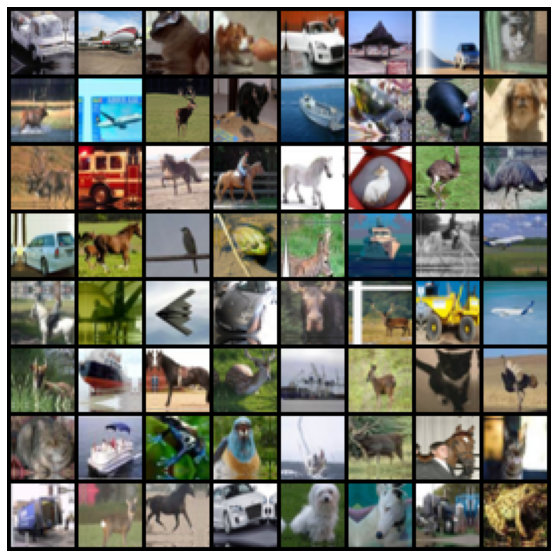

In [63]:
showbatch(train_dl)

**Gpu interfacing functions**

In [64]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data,device):
    if isinstance(data ,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device)

class DeviceDataLoader:
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [65]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

# Residual Neural Network with Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


In [66]:
class SimpleResudialBlock(nn.Module) :
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
    def forward(self,x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.conv2(out)
        return self.relu2(out) + x #we'll add the input after applying relu
#Note:for a residual block input channels and output channels of inside layers should be same

In [67]:
simple_res= to_device(SimpleResudialBlock(),device)
for img,_ in train_dl:
    print(img.shape)
    out=simple_res(img)
    print(out.shape)
    break

del simple_res,img,_
torch.cuda.empty_cache()

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


In [77]:
#Base Training model
class BaseModel(nn.Module):
    def train_step(self,batch):
        img,label=batch
        out=self(img)
        loss=F.cross_entropy(out,label)
        return loss
    def val_step(self,batch):
        img,label=batch
        out=self(img)
        loss=F.cross_entropy(out,label)
        acc=accuracy(out,label)
        return {'val_loss':loss,'val_acc':acc}
    def val_epoch_end(self,outputs):
        batch_loss=[i['val_loss'] for i in outputs]
        batch_acc=[i['val_acc'] for i in outputs]
        epoch_loss=torch.stack(batch_loss).mean()
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [78]:
def conv_block(in_ch,out_ch,pool=False):
    '''Represents single convolution block'''
    layers=[nn.Conv2d(in_ch,out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()]
    if pool:
        layers.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*layers)

class ResNet9(BaseModel):
    def __init__(self):
        super().__init__()
        #in 32*32*3
        self.conv1=conv_block(3,64)   #32*32*64
        self.conv2=conv_block(64,128,True) #16*16*128
        
        self.res1=nn.Sequential(conv_block(128,128),
                                conv_block(128,128))
        self.conv3=conv_block(128,256,True) #8*8*256
        self.conv4=conv_block(256,512,True) #4*4*512
        self.res2=nn.Sequential(conv_block(512,512),
                                conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.MaxPool2d(4), #1*1*512
                                      nn.Flatten(),  #512
                                      nn.Dropout(0.2), #removing 20% of activations
                                      nn.Linear(512,10)
                                     ) 
    def forward(self,x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out                        

In [79]:
model=to_device(ResNet9(),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv3): Sequential(
    (0): Co

## Training Model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.(sets a maximum threshold for gradients) Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [80]:
@torch.no_grad()
def evaluate(model,val_loadr):
  model.eval()    #for evaluating behaviour of layers like dropout turned off
  outs=[model.val_step(b) for b in val_loadr]
  return model.val_epoch_end(outs)

def get_lr(optimizer):
  '''Returns current learning rate of optimizer'''
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit(model,epochs,train_dl,val_dl,max_lr,weight_decay=0,grad_clip=None,opt=torch.optim.SGD):
  
  torch.cuda.empty_cache()    #cleans the gpu memory to utilize it
  history=[]
  optim=opt(model.parameters(),max_lr,weight_decay=weight_decay) #optimizer with weight decay param
  one_lr=torch.optim.lr_scheduler.OneCycleLR( optimizer=optim,max_lr=max_lr,
                                             epochs=epochs,
                                             steps_per_epoch=len(train_dl))  #one cycle scheduler
  for epoch in range(epochs):
    #training phase
    model.train()       #to specify training behaviour of layers
    lrs=[]
    train_loss=[]
    for b in train_dl:
      loss=model.train_step(b)
      train_loss.append(loss)
      loss.backward()
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)
      optim.step()
      optim.zero_grad()
      #record and update lrs
      lrs.append(get_lr(optim))
      one_lr.step()
    #validation phase
    result=evaluate(model,val_dl)
    result['train_loss']=torch.stack(train_loss).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [81]:
torch.optim.SGD(model.parameters(),0.1).param_groups[0]['lr'] 

0.1

In [82]:
history=[evaluate(model,val_dl)]
history[0]

{'val_acc': 0.09775390475988388, 'val_loss': 2.304094076156616}

In [83]:
epochs=15
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
optim=torch.optim.Adam

In [84]:
%%time
history+=fit(model,epochs,train_dl,val_dl,max_lr,weight_decay,grad_clip,optim)

Epoch [0], train_loss: 1.5342, val_loss: 1.1348, val_acc: 0.6003
Epoch [1], train_loss: 1.0336, val_loss: 1.0741, val_acc: 0.6518
Epoch [2], train_loss: 0.8784, val_loss: 0.8057, val_acc: 0.7278
Epoch [3], train_loss: 0.7861, val_loss: 0.9775, val_acc: 0.6712
Epoch [4], train_loss: 0.6329, val_loss: 0.6766, val_acc: 0.7717
Epoch [5], train_loss: 0.5350, val_loss: 0.7387, val_acc: 0.7478
Epoch [6], train_loss: 0.4665, val_loss: 0.5756, val_acc: 0.8098
Epoch [7], train_loss: 0.4140, val_loss: 0.5663, val_acc: 0.8065
Epoch [8], train_loss: 0.3659, val_loss: 0.5267, val_acc: 0.8213
Epoch [9], train_loss: 0.3118, val_loss: 0.4367, val_acc: 0.8571
Epoch [10], train_loss: 0.2550, val_loss: 0.3763, val_acc: 0.8792
Epoch [11], train_loss: 0.2019, val_loss: 0.3136, val_acc: 0.8986
Epoch [12], train_loss: 0.1480, val_loss: 0.2645, val_acc: 0.9155
Epoch [13], train_loss: 0.1023, val_loss: 0.2318, val_acc: 0.9257
Epoch [14], train_loss: 0.0874, val_loss: 0.2309, val_acc: 0.9265
CPU times: user 1min

**Saving trained model**

In [85]:
torch.save(model.state_dict(),'cifar10_resnet9-01.pth')

**model insights**

In [91]:
def plot_acc(history):
  accs=[i['val_acc'] for i in history]
  plt.plot(accs,'-rx')
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

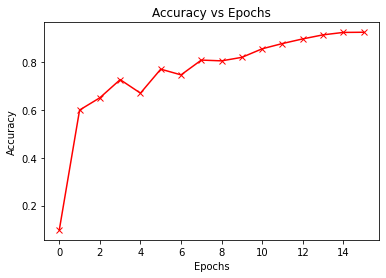

In [92]:
plot_acc(history)

In [97]:
def plot_loss(history):
  valoss=[i['val_loss'] for i in history]
  trloss=[i['train_loss'] for i in history[1:]]
  plt.plot(valoss,'-rx')
  plt.plot(trloss,'-bx')
  plt.title('Loss vs Epochs')
  plt.legend(['Validation','Training'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

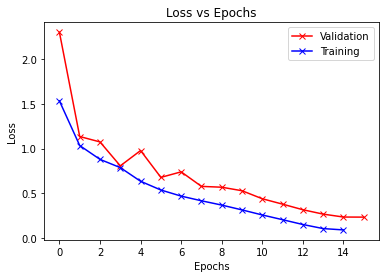

In [98]:
plot_loss(history)

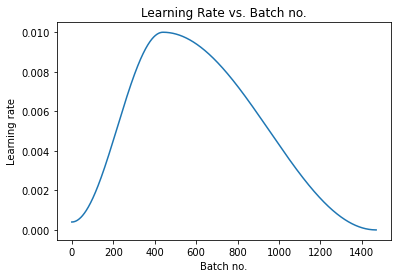

In [100]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history) #one cycle

## Predicting on images

In [105]:
def predict(data):
  img,label=data
  out=model(to_device(img.unsqueeze(0),device))
  _,pred=torch.max(out,dim=1)
  plt.imshow(img.permute(1,2,0).clamp(0,1))
  plt.title(f'Label:{train_ds.classes[label]} Prediction:{train_ds.classes[pred[0].item()]}')
  plt.axis('off')
  plt.show()

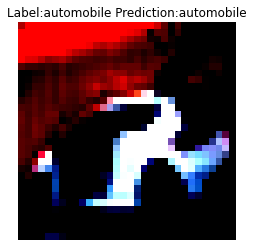

In [108]:
predict(val_ds[1000])

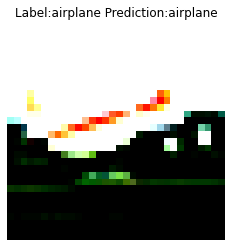

In [109]:
predict(val_ds[100])

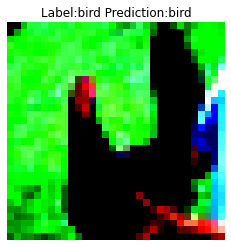

In [111]:
predict(val_ds[2000])